# Set up

In [1]:
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import warnings
import xrft

warnings.filterwarnings('ignore')

from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import setup_random_seeds, get_device, open_zarr, min_max_normalize

setup_random_seeds(42)
device = get_device()

# DATA LOADING
base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)


# PREPARE TEST DATA
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

test_dataset = TensorDataset(x_test_normalized, y_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# LOAD MODEL & EVALUATE
model = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4).to(device)
checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Store results
results = {
    'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

def generate_gaussian_samples(mu, log_sigma, n_samples=100):
    """Generate samples from Gaussian distribution."""
    sigma = torch.exp(log_sigma)
    samples = mu.unsqueeze(1) + sigma.unsqueeze(1) * torch.randn(
        mu.shape[0], n_samples, *mu.shape[1:], device=mu.device
    )
    return samples

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(tqdm(test_loader)):
        batch_start = i * test_loader.batch_size
        batch_end = min(batch_start + test_loader.batch_size, len(test_dataset))
        current_batch_indices = list(range(batch_start, batch_end))
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model(batch_x)
        
        ssh_batch = x_test_ssh_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch - ubm_true
        
        # Predicted mean
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        bm_pred_mu = ssh_batch - ubm_pred_mu
        
        # Ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=100)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        ssh_expanded = ssh_batch.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        results['ubm_true'].append(ubm_true.cpu().numpy())
        results['bm_true'].append(bm_true.cpu().numpy())
        results['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

# Concatenate all results
for key in results:
    results[key] = np.concatenate(results[key], axis=0)


# CREATE XARRAY DATASET
n_samples = results['ubm_true'].shape[0]
ds = xr.Dataset({
    'ubm_truth': (['sample', 'channel', 'i', 'j'], results['ubm_true']),
    'bm_truth': (['sample', 'channel', 'i', 'j'], results['bm_true']),
    'ubm_pred_mean': (['sample', 'channel', 'i', 'j'], results['ubm_pred_mu']),
    'bm_pred_mean': (['sample', 'channel', 'i', 'j'], results['bm_pred_mu']),
    'ubm_pred_samples': (['sample', 'stochastic_sample', 'channel', 'i', 'j'], 
                         results['ubm_pred_ensembles']),
    'bm_pred_samples': (['sample', 'stochastic_sample', 'channel', 'i', 'j'], 
                        results['bm_pred_ensembles'])
})

# Squeeze out channel dimension for easier plotting
for var in ds.data_vars:
    ds[var] = ds[var].squeeze('channel')


# SPECTRAL BINNING FUNCTIONS
def isotropic_spectra(data):
    """Calculate isotropic power spectrum."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, dim=['i', 'j'], detrend='constant', window=True, nfactor=2
    )
    return iso_psd

def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(field, dims=['i', 'j'], coords={'i': i_km, 'j': j_km})
    return isotropic_spectra(da)

def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find first intersection between BM and UBM PSDs."""
    try:
        diff = ubm_psd - bm_psd
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        if len(sign_changes) == 0:
            return None
        
        first_idx = sign_changes[0]
        k1, k2 = wavenumbers[first_idx], wavenumbers[first_idx + 1]
        d1, d2 = diff[first_idx], diff[first_idx + 1]
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        return intersection_k
    except:
        return None

def custom_bins(): 
    return np.array([1/120, 1/40, 1/10, 1/1])

def bin_samples_by_intersection(ds, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers."""
    bin_edges = custom_bins()
    n_bins = len(bin_edges) - 1
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    
    for sample_idx in tqdm(clean_idx_subset):
        try:
            bm_true = ds.bm_truth.isel(sample=sample_idx).values
            ubm_true = ds.ubm_truth.isel(sample=sample_idx).values
            
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
                
            psd_bm = calculate_psd_km(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            if intersection_k is not None:
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
        except:
            continue
    
    return bins

# BIN SAMPLES BY INTERSECTION WAVENUMBERS
clean_idx_subset = np.arange(len(ds.sample))
bins = bin_samples_by_intersection(ds, test, clean_idx_subset)

Using device: cpu


100%|██████████| 3645/3645 [01:12<00:00, 50.61it/s] 


# Plot

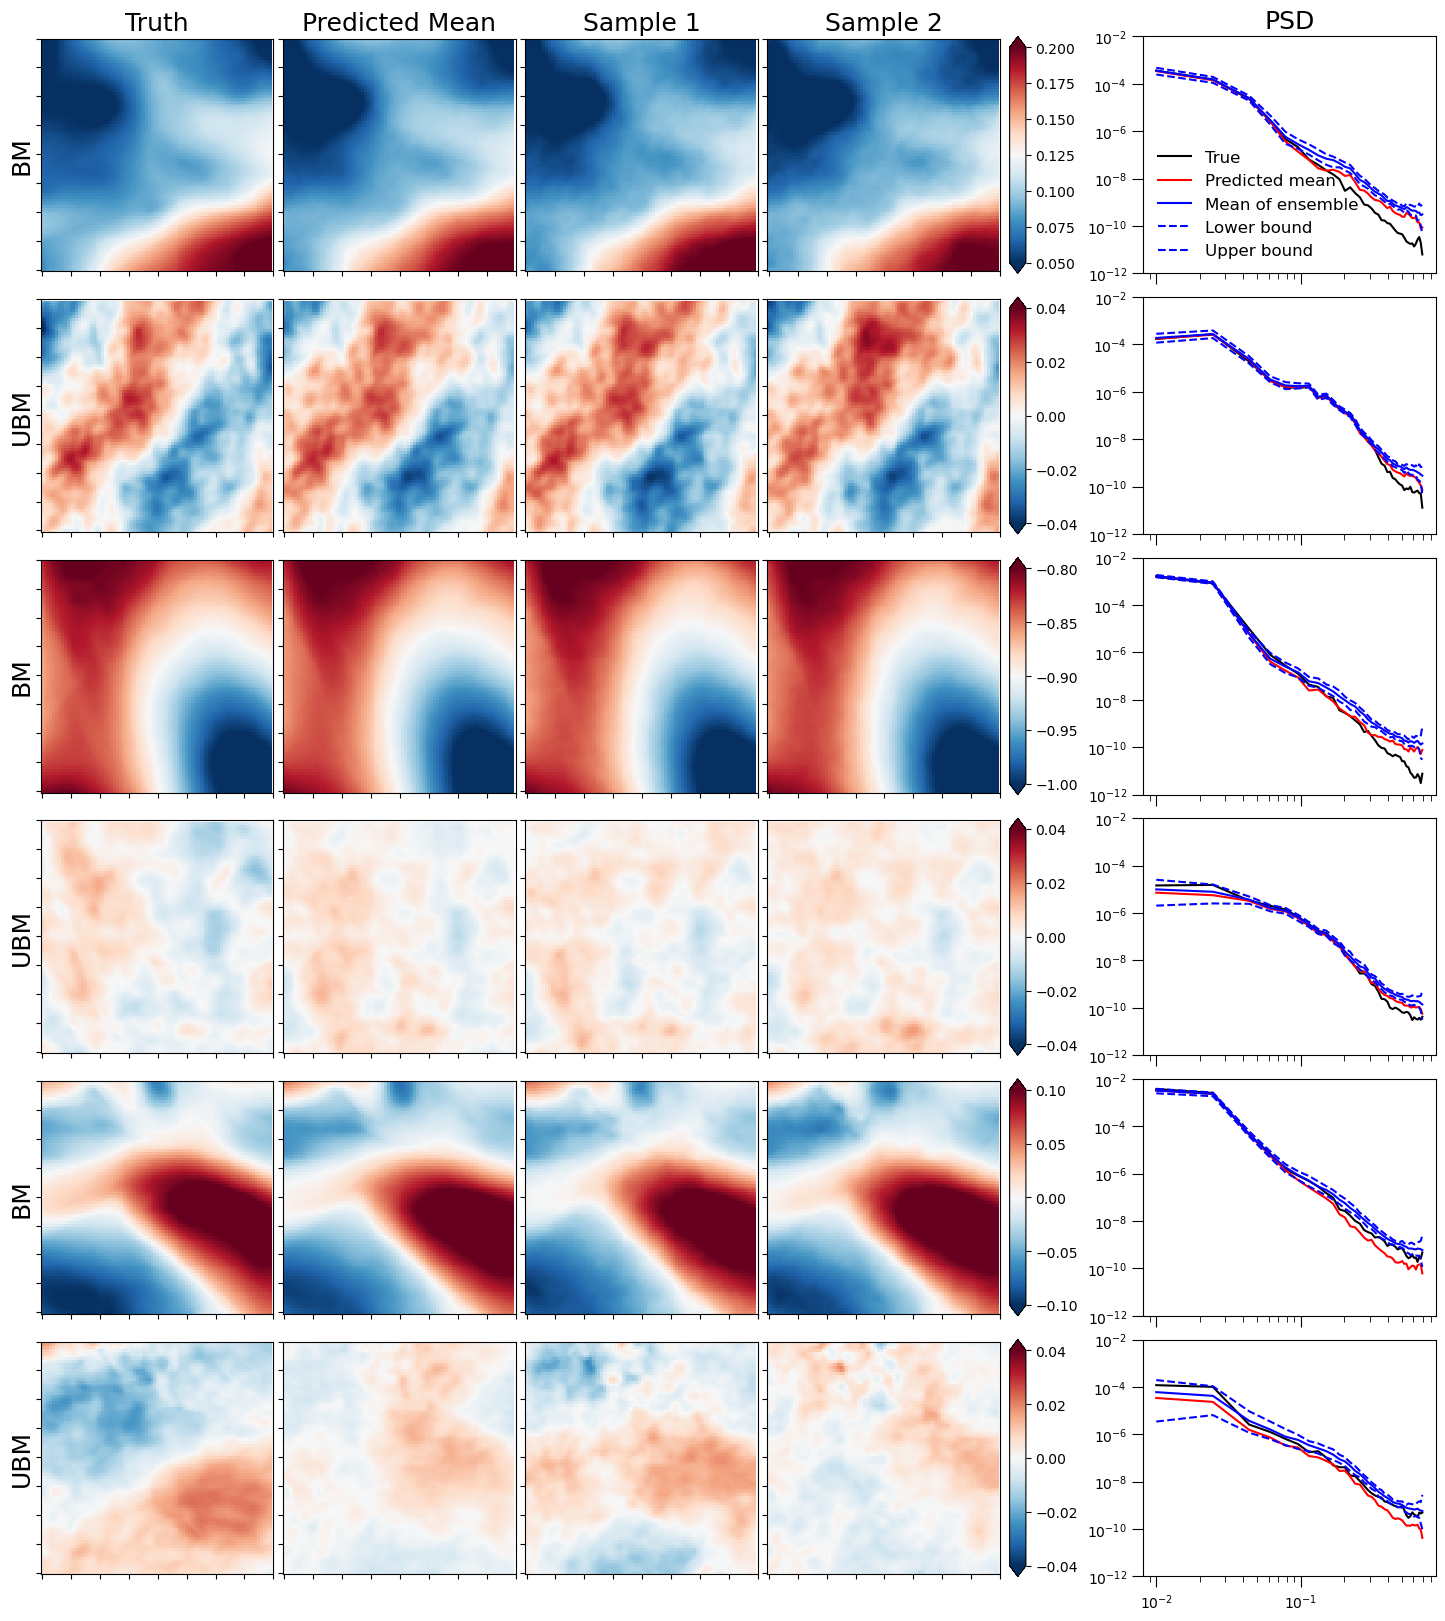

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# Row configurations: (bin_name, model_type, vmin, vmax, data_type, cmap)
plot_configs = [
    ('bin_0', 'BM', 0.05, 0.20, 'bm', 'RdBu_r'),
    ('bin_0', 'UBM', -0.04, 0.04, 'ubm', 'RdBu_r'),
    ('bin_1', 'BM', -1, -0.8, 'bm', 'RdBu_r'),
    ('bin_1', 'UBM', -0.04, 0.04, 'ubm', 'RdBu_r'),
    ('bin_2', 'BM', -0.1, 0.1, 'bm', 'RdBu_r'),
    ('bin_2', 'UBM', -0.04, 0.04, 'ubm', 'RdBu_r')
]

plot_specs = [
    ('Truth', lambda nsamp, data_type: getattr(ds, f'{data_type}_truth').sel(sample=nsamp)),
    ('Predicted Mean', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp)),
    ('Sample 1', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 2', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=10))
]

fig = plt.figure(figsize=(18, 20))
plt.rcParams['axes.titlesize'] = 18  
plt.rcParams['legend.fontsize'] = 12  

# Main grid: 6 rows, 3 major columns (images+colorbar, gap, PSD)
gs_main = GridSpec(6, 3, figure=fig, width_ratios=[5.05, 0.6, 1.5], 
                   wspace=0.00, hspace=0.1)

for row, (bin_name, model_type, vmin, vmax, data_type, cmap) in enumerate(plot_configs):
    nsamp = bins[bin_name][5]
    
    # Create sub-gridspec for images and colorbar (tight spacing)
    gs_images = GridSpecFromSubplotSpec(1, 5, subplot_spec=gs_main[row, 0], 
                                        width_ratios=[1, 1, 1, 1, 0.07], 
                                        wspace=0.05, hspace=0)
    
    # Plot the 4 spatial panels
    for col, (title, data_func) in enumerate(plot_specs):
        ax = fig.add_subplot(gs_images[0, col])
        
        data = data_func(nsamp, data_type)
        
        im = data.plot(
            ax=ax,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            extend='both',
            add_colorbar=False
        )
        
        # Only add title for first row
        if row == 0:
            ax.set_title(f'{title}')
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_aspect('equal')
        
        # Set 8 equally spaced ticks
        tick_positions = np.linspace(0, 80, 9)
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Add row label (BM/UBM) to the left of first column
        if col == 0:
            ax.text(-0.08, 0.5, model_type, transform=ax.transAxes,
                   fontsize=18, va='center', ha='center', rotation=90)
    
    # Add shared colorbar in the sub-grid
    cax = fig.add_subplot(gs_images[0, 4])
    cbar = plt.colorbar(im, cax=cax, extend='both', shrink=0.5)

    # Add PSD panel in the main grid (separate column with gap)
    ax_psd = fig.add_subplot(gs_main[row, 2])
    
    psd_true = isotropic_spectra(getattr(ds, f'{data_type}_truth').sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp))
    
    # Calculate full range envelope from all ensemble samples
    psd_ensemble_min = psd_pred_samp.min('stochastic_sample')
    psd_ensemble_max = psd_pred_samp.max('stochastic_sample')
    psd_ensemble_mean = psd_pred_samp.mean('stochastic_sample')
    
    # Plot true and predicted mean
    psd_true.plot(ax=ax_psd, color='k', label='True')
    psd_pred_mean.plot(ax=ax_psd, color='r', label='Predicted mean')
    psd_ensemble_mean.plot(ax=ax_psd, color='b', label='Mean of ensemble')
    
    # Plot min and max as dashed lines
    psd_ensemble_min.plot(ax=ax_psd, color='b', linestyle='--', label='Lower bound')
    psd_ensemble_max.plot(ax=ax_psd, color='b', linestyle='--', label='Upper bound')
    
    ax_psd.set_xscale('log')
    ax_psd.set_xlabel('')
    ax_psd.set_yscale('log')

    # Only show x-axis label on last row
    if row < 5:
        ax_psd.set_xticklabels([])
    
    ax_psd.set_ylim([1e-12, 1e-2])

    # Increase tick length for both axes
    ax_psd.tick_params(axis='both', which='major', length=8)
    ax_psd.tick_params(axis='both', which='minor', length=4)
    
    # Only add PSD title for first row
    if row == 0:
        ax_psd.set_title('PSD')
        ax_psd.legend(frameon=False, loc='lower left')

plt.savefig('figures/publication_figure5.png', dpi=300, bbox_inches='tight')
plt.show()

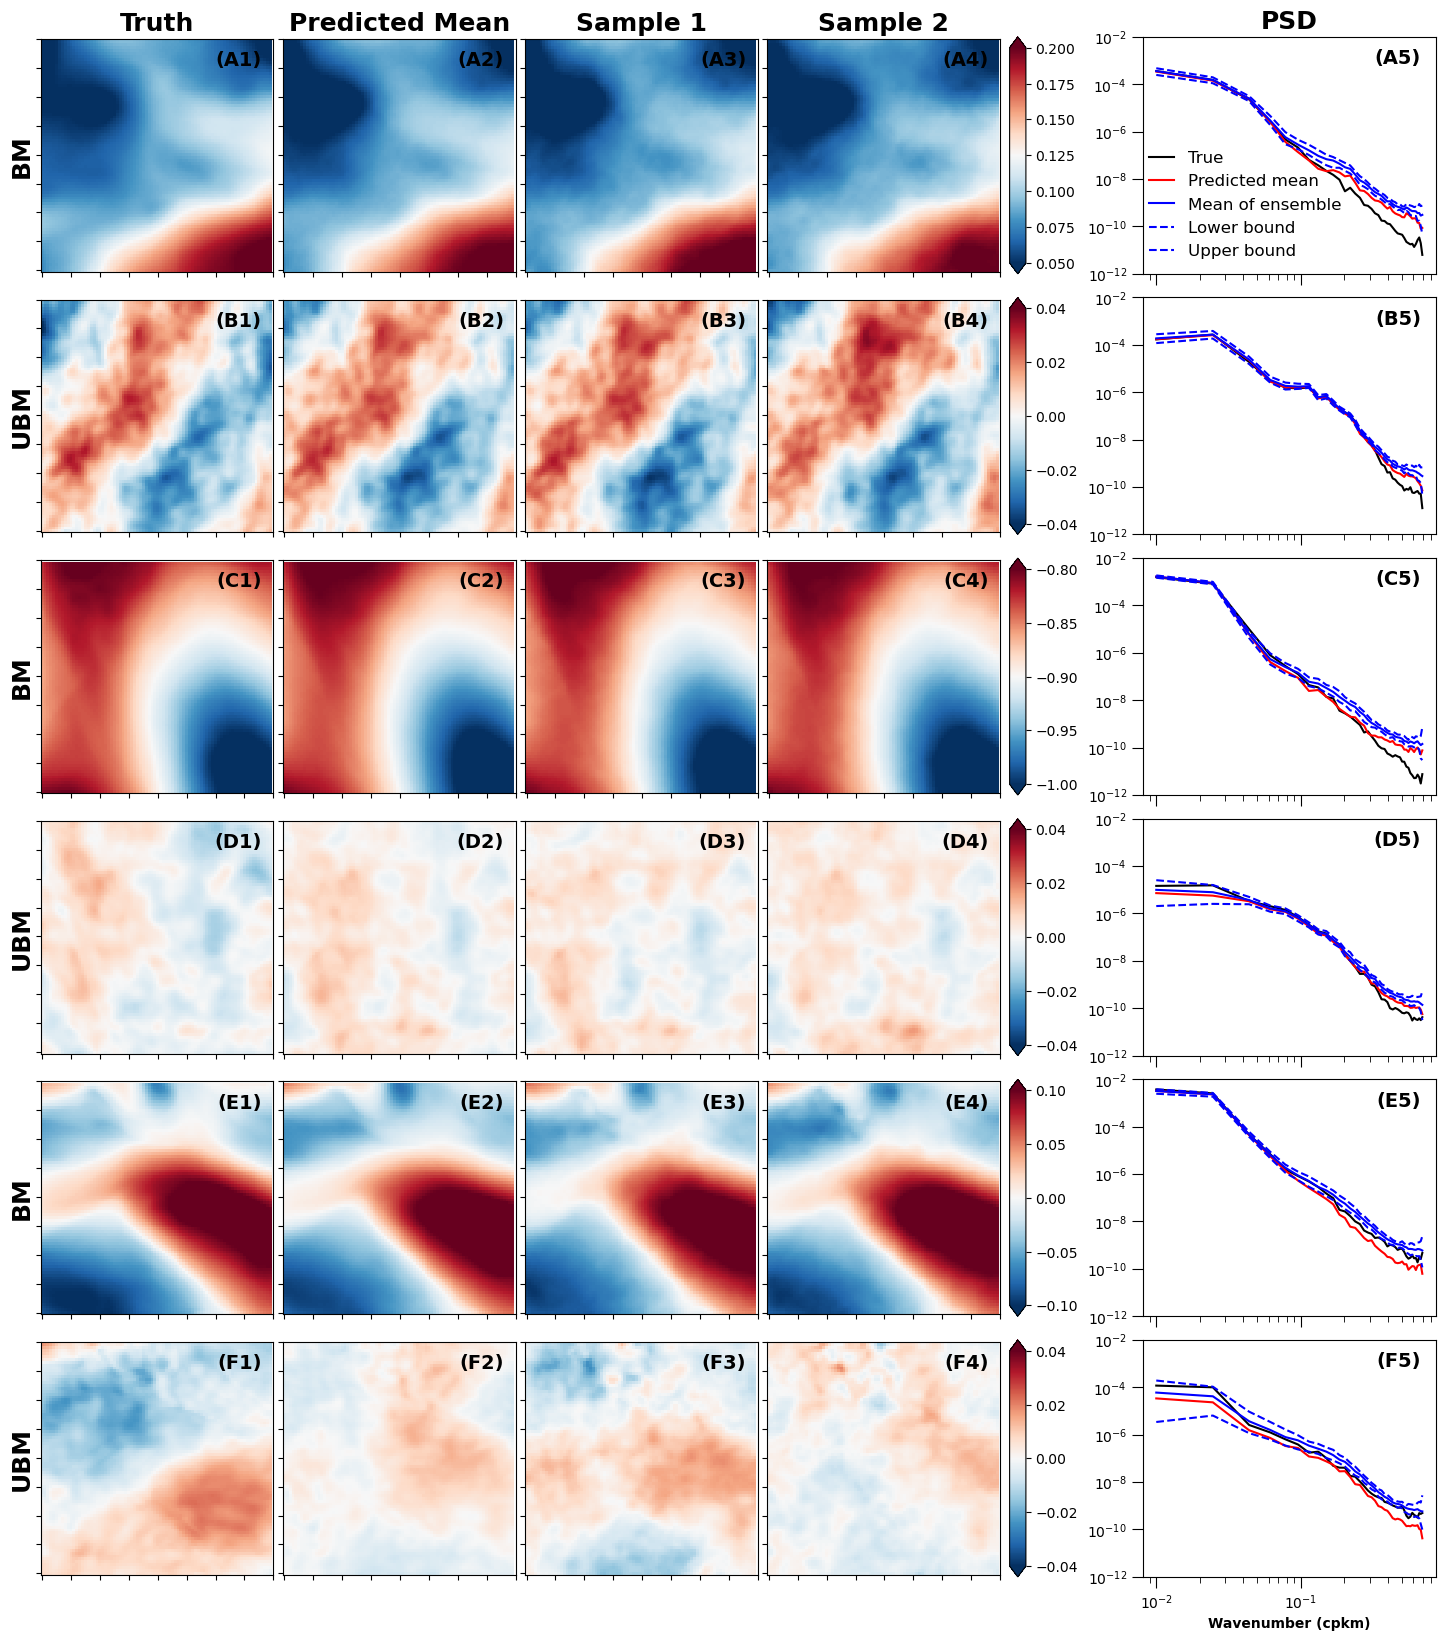

In [16]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# Row configurations: (bin_name, model_type, vmin, vmax, data_type, cmap)
plot_configs = [
    ('bin_0', 'BM', 0.05, 0.20, 'bm', 'RdBu_r'),
    ('bin_0', 'UBM', -0.04, 0.04, 'ubm', 'RdBu_r'),
    ('bin_1', 'BM', -1, -0.8, 'bm', 'RdBu_r'),
    ('bin_1', 'UBM', -0.04, 0.04, 'ubm', 'RdBu_r'),
    ('bin_2', 'BM', -0.1, 0.1, 'bm', 'RdBu_r'),
    ('bin_2', 'UBM', -0.04, 0.04, 'ubm', 'RdBu_r')
]

plot_specs = [
    ('Truth', lambda nsamp, data_type: getattr(ds, f'{data_type}_truth').sel(sample=nsamp)),
    ('Predicted Mean', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp)),
    ('Sample 1', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 2', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=10))
]

fig = plt.figure(figsize=(18, 20))
plt.rcParams['axes.titlesize'] = 18  
plt.rcParams['legend.fontsize'] = 12  

# Main grid: 6 rows, 3 major columns (images+colorbar, gap, PSD)
gs_main = GridSpec(6, 3, figure=fig, width_ratios=[5.05, 0.6, 1.5], 
                   wspace=0.00, hspace=0.1)

row_labels = ['A', 'B', 'C', 'D', 'E', 'F']

for row, (bin_name, model_type, vmin, vmax, data_type, cmap) in enumerate(plot_configs):
    nsamp = bins[bin_name][5]
    
    # Create sub-gridspec for images and colorbar (tight spacing)
    gs_images = GridSpecFromSubplotSpec(1, 5, subplot_spec=gs_main[row, 0], 
                                        width_ratios=[1, 1, 1, 1, 0.07], 
                                        wspace=0.05, hspace=0)
    
    # Plot the 4 spatial panels
    for col, (title, data_func) in enumerate(plot_specs):
        ax = fig.add_subplot(gs_images[0, col])
        
        data = data_func(nsamp, data_type)
        
        im = data.plot(
            ax=ax,
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            extend='both',
            add_colorbar=False
        )
        
        # Only add title for first row
        if row == 0:
            ax.set_title(f'{title}', fontweight='bold')
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_aspect('equal')
        
        # Set 8 equally spaced ticks
        tick_positions = np.linspace(0, 80, 9)
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Add panel label
        panel_label = f'({row_labels[row]}{col+1})'
        ax.text(0.95, 0.95, panel_label, transform=ax.transAxes,
               fontsize=14, va='top', ha='right', fontweight='bold')

        # Add row label (BM/UBM) to the left of first column
        if col == 0:
            ax.text(-0.08, 0.5, model_type, transform=ax.transAxes,
                   fontsize=18, va='center', ha='center', rotation=90, fontweight='bold')
    
    # Add shared colorbar in the sub-grid
    cax = fig.add_subplot(gs_images[0, 4])
    cbar = plt.colorbar(im, cax=cax, extend='both', shrink=0.5)

    # Add PSD panel in the main grid (separate column with gap)
    ax_psd = fig.add_subplot(gs_main[row, 2])
    
    psd_true = isotropic_spectra(getattr(ds, f'{data_type}_truth').sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp))
    
    # Calculate full range envelope from all ensemble samples
    psd_ensemble_min = psd_pred_samp.min('stochastic_sample')
    psd_ensemble_max = psd_pred_samp.max('stochastic_sample')
    psd_ensemble_mean = psd_pred_samp.mean('stochastic_sample')
    
    # Plot true and predicted mean
    psd_true.plot(ax=ax_psd, color='k', label='True')
    psd_pred_mean.plot(ax=ax_psd, color='r', label='Predicted mean')
    psd_ensemble_mean.plot(ax=ax_psd, color='b', label='Mean of ensemble')
    
    # Plot min and max as dashed lines
    psd_ensemble_min.plot(ax=ax_psd, color='b', linestyle='--', label='Lower bound')
    psd_ensemble_max.plot(ax=ax_psd, color='b', linestyle='--', label='Upper bound')
    
    ax_psd.set_xscale('log')
    ax_psd.set_xlabel('')
    ax_psd.set_yscale('log')

    # Add x-axis label for last row
    if row == 5:
        ax_psd.set_xlabel('Wavenumber (cpkm)', fontweight='bold')
    
    # Only show x-axis ticks on last row
    if row < 5:
        ax_psd.set_xticklabels([])
    
    ax_psd.set_ylim([1e-12, 1e-2])

    # Increase tick length for both axes
    ax_psd.tick_params(axis='both', which='major', length=8)
    ax_psd.tick_params(axis='both', which='minor', length=4)
    
    # Add panel label for PSD
    panel_label = f'({row_labels[row]}5)'
    ax_psd.text(0.95, 0.95, panel_label, transform=ax_psd.transAxes,
               fontsize=14, va='top', ha='right', fontweight='bold')
    
    # Only add PSD title for first row
    if row == 0:
        ax_psd.set_title('PSD', fontweight='bold')
        ax_psd.legend(frameon=False, loc='lower left', bbox_to_anchor=(-0.03, 0), handlelength=1.5)

plt.savefig('figures/publication_figure5.png', dpi=600, bbox_inches='tight')
plt.show()